In [2]:
import CellMemory as cellmemory
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
# ***************************** #
# >>>          Train        <<< #
# ***************************** #
batch_size = 140
Dataset = 'data/demo_hBreast_train.h5ad'  # train data path
Label = 'broad_cell_type'   # the .obs label
Project = 'hBreast_TAGs'  # Project name


# *********************************** #
# >> Forming intuition for cells.. << #
# *********************************** #
Reading Data: hBreast_TAGs
Train set: (80000, 3000)
Valid set: (20000, 3000)
Batch size: 140
Max bins: 10
Learning Categories: 10
use topk: False
CellMemory is delineating cell representations..

----- [Epoch: 1] -----
Train >>>
Loss: 0.388   Acc: 86.78   F1 (Macro): 84.51
Valid >>>
Loss: 0.026   Acc: 99.14   F1 (Macro): 98.40
Saving..
Run time: 287 s

----- [Epoch: 2] -----
Train >>>
Loss: 0.026   Acc: 99.24   F1 (Macro): 98.76
Valid >>>
Loss: 0.017   Acc: 99.45   F1 (Macro): 99.12
Saving..
Run time: 266 s

----- [Epoch: 3] -----
Train >>>
Loss: 0.017   Acc: 99.49   F1 (Macro): 99.23
Valid >>>
Loss: 0.013   Acc: 99.62   F1 (Macro): 99.17
Saving..
Run time: 266 s

----- [Epoch: 4] -----
Train >>>
Loss: 0.013   Acc: 99.61   F1 (Macro): 99.39
Valid >>>
Loss: 0.011   Acc: 99.67   F1 (Macro): 99.37
Saving..
Run time: 257 s

----- [Epoch: 5] -----
Train >>>
Loss: 0.012   

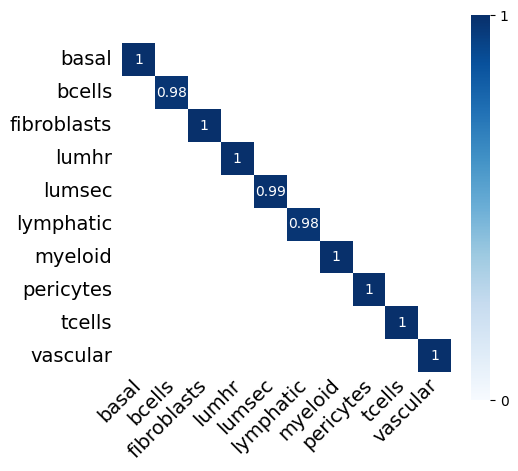

In [3]:
# train the model
cellmemory.train(Dataset, Label=Label, Project=Project, batch_size=batch_size, valid_id=0)

In [4]:
# check the output file 
from pprint import pprint
file = os.listdir(Project)
pprint(file)

['fig_conf_mat_valid.pdf',
 'hBreast_TAGs_ckpt.pth',
 'MaxBin.txt',
 'hBreast_TAGs_ref_gene.txt',
 'hBreast_TAGs_idx2celltype.txt',
 'fig_loss.pdf',
 'fig_f1.pdf',
 'fig_acc.pdf']


In [4]:
# ***************************** #
# >>>        Predict        <<< #
# ***************************** #
Model = Project+'_ckpt.pth'
batch_size=70
test_data = sc.read_h5ad('data/demo_hBreast_test.h5ad')  # test dataset

In [5]:
# predict the query data
adata_pred, total_attn, AttentionGene = cellmemory.predict(test_data, Model, Project=Project, batch_size=batch_size, out_Tag=True)


Loading Model from: hBreast_TAGs
Reference Categories: 10
Query set: (144285, 3000)
Query Max bins: 9
Ref Max bins: 10
Do not Need Padding
use topk: False
==> Resuming from checkpoint..
CellMemory is deciphering query cells..


In [6]:
# access the performance
cellmemory.assess(test_data.obs[Label], adata_pred.obs['Pred'])

Accuracy is 99.60
F1 score(Macro) is 99.34


In [7]:
# ***************************** #
# >>>          Plot         <<< #
# ***************************** #
import plot

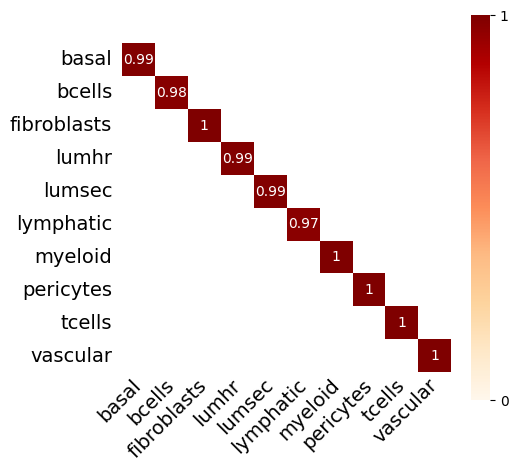

In [8]:
# plot confusion matrix
os.chdir(Project)
plot.plot_conf_mat(
            test_data.obs[Label], 
            adata_pred.obs['Pred'], 
            'ConfMat_'+Project+'_test.pdf', 
            cmap='OrRd'
)

In [9]:
sc.pp.pca(adata_pred)
sc.pp.neighbors(adata_pred)
sc.tl.umap(adata_pred)

adata_pred.obs['celltype'] = list(test_data.obs[Label])
adata_pred

AnnData object with n_obs × n_vars = 144285 × 256
    obs: 'Pred', 'Pred_prob', 'celltype'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

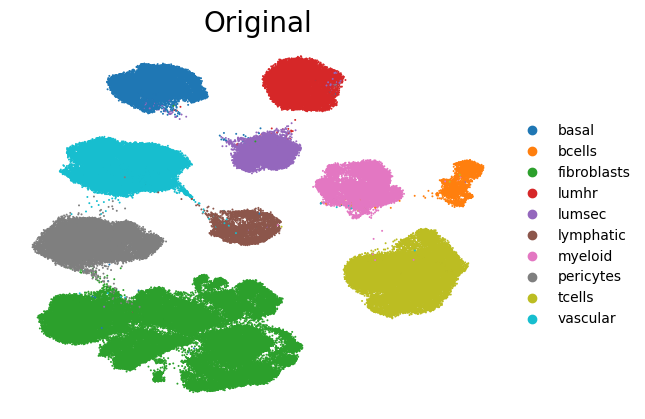

In [11]:
# plot the original label on cls umap
sc.pl.umap(adata_pred, color='celltype', frameon=False, show=False, size=8)
plt.title('Original', fontsize=20)
plt.savefig('cls_celltype.pdf', dpi=300, bbox_inches="tight")

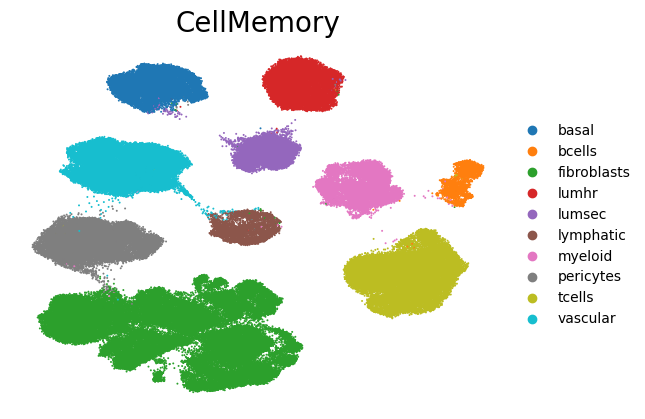

In [12]:
# plot the pred label on cls umap
sc.pl.umap(adata_pred, color='Pred', frameon=False, show=False, size=8)
plt.title('CellMemory', fontsize=20)
plt.savefig('cls_Pred.pdf', dpi=300, bbox_inches="tight")

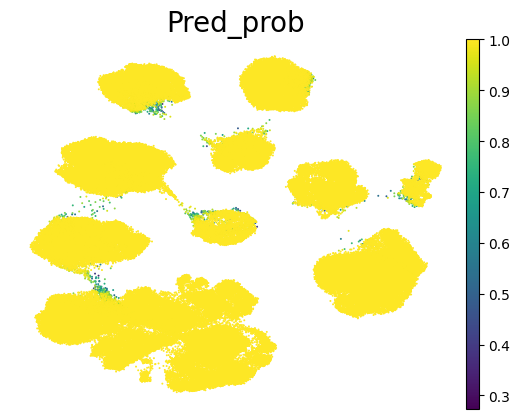

In [13]:
# plot the confidence score on cls umap
sc.pl.umap(adata_pred, color='Pred_prob', frameon=False, show=False, size=8)
plt.title('Pred_prob', fontsize=20)
plt.savefig('cls_Pred_prob.pdf', dpi=300, bbox_inches="tight")

plotting attention score ..


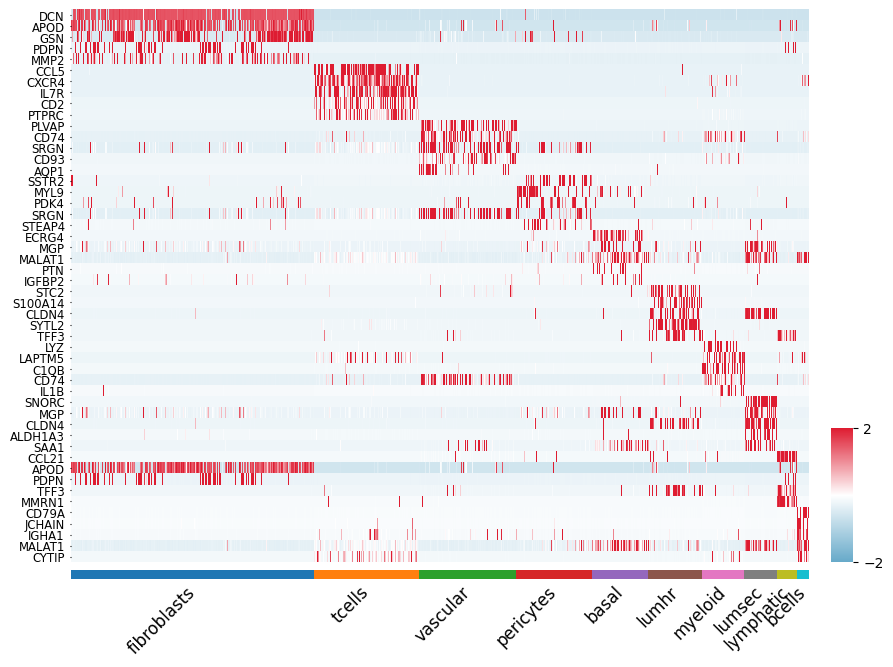

plotting experssion signal ..


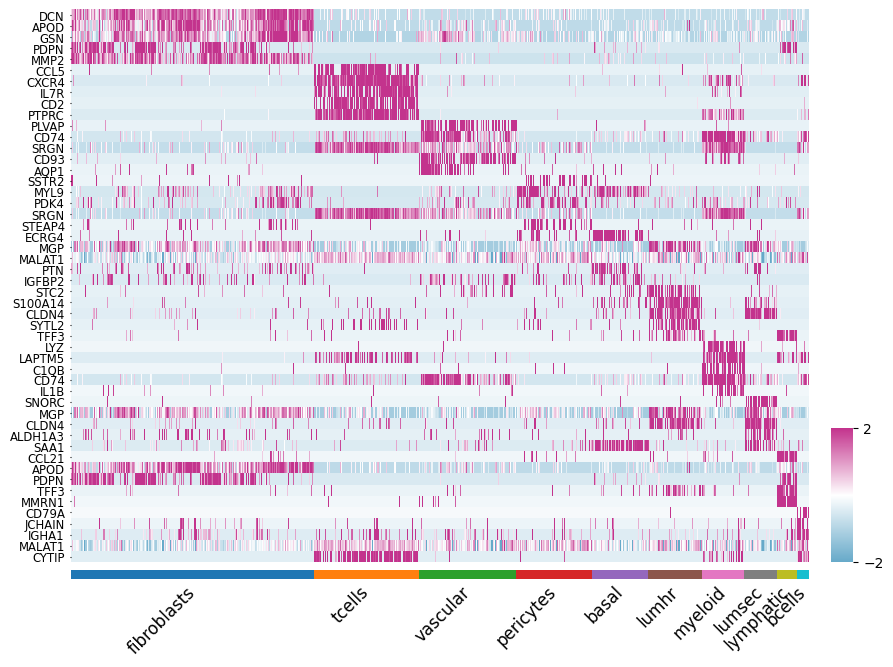

In [14]:
# plot the heatmap (Attention score and Exp signal) of TAGs 
plot.plot_tag_heatmap(
            test_data, 
            adata_pred, 
            total_attn, 
            AttentionGene
)

In [15]:
# write
adata_pred.write('cls_'+Project+'.h5ad')
np.save('cls_attn.npy', np.array(total_attn))
AttentionGene.to_csv('AttentionGene.txt', index=0)